## Assignment 2: Time Series Forecasting

### \<Qingyan Yang> \<a1865304>

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

import related python packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

read data

In [35]:
df = pd.read_csv('energydata_complete.csv')

show useful information of data

In [36]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [37]:
df.shape


(19735, 29)

In [38]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

date is object type, some information from it should be transfer to numerical value, such as seconds from midnight (Candanedo et al 2017, p. 85),since every feature value changes with date, will do it in data processing, because need to uniform data first.

In [39]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

list all useful information of the data;
after observation, no obvious useless data columns need to be droped;

but the name should be uniformed, start with upper class letter

In [40]:
#name should be uniformed, start with upper class letter, and add '_' before number
col_names = ['Date', 'Appliances', 'Lights', 'T_1', 'RH_1', 'T_2', 'RH_2', 'T_3',
             'RH_3', 'T_4', 'RH_4', 'T_5', 'RH_5', 'T_6', 'RH_6', 'T_7', 'RH_7', 'T_8',
             'RH_8', 'T_9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
             'Visibility', 'Tdewpoint', 'RV_1', 'RV_2']

df.columns = col_names

df.columns

Index(['Date', 'Appliances', 'Lights', 'T_1', 'RH_1', 'T_2', 'RH_2', 'T_3',
       'RH_3', 'T_4', 'RH_4', 'T_5', 'RH_5', 'T_6', 'RH_6', 'T_7', 'RH_7',
       'T_8', 'RH_8', 'T_9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'RV_1', 'RV_2'],
      dtype='object')

In [41]:
#checking for null values
df.isnull().sum()


Date           0
Appliances     0
Lights         0
T_1            0
RH_1           0
T_2            0
RH_2           0
T_3            0
RH_3           0
T_4            0
RH_4           0
T_5            0
RH_5           0
T_6            0
RH_6           0
T_7            0
RH_7           0
T_8            0
RH_8           0
T_9            0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
RV_1           0
RV_2           0
dtype: int64

there is no null value

#### Data Preprocessing

In [42]:
#strip space of colomn Date
np.unique(df.Date)
df['Date'] = df['Date'].str.strip()

In [43]:
# check if there is invalid value 
df.loc[df['Date']=='?']

,Date,Appliances,Lights,T_1,RH_1,T_2,RH_2,T_3,RH_3,T_4,...,T_9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,RV_1,RV_2


In [44]:
# Adding new columns in the dataset

# convert datetime column to pandas datetime object
df['Date'] = pd.to_datetime(df['Date'])
# want to show the relationship between appliances and various of time
df['Day_of_week'] = df['Date'].dt.dayofweek
df['Time_period'] = pd.cut(df['Date'].dt.hour, bins=24, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
# convert Time_period to numeric data type
df['Time_period'] = df['Time_period'].astype(int)

#create dataframe for last 4-week, to observe seasonal impact
first_date = df['Date'].min()
four_weeks_later = first_date + pd.Timedelta(weeks=4)
df_first_four_weeks = df[df['Date'] < four_weeks_later]

In [45]:
df.head()

,Date,Appliances,Lights,T_1,RH_1,T_2,RH_2,T_3,RH_3,T_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,RV_1,RV_2,Day_of_week,Time_period
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,0,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,0,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,17
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,17
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,17


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   Lights       19735 non-null  int64         
 3   T_1          19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T_2          19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T_3          19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T_4          19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T_5          19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T_6          19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T_7          19735 non-null  float64       
 16  RH_7

data processing done!

### 2. Analyse and visualise the data

The data of appliance is the target that we want to analysis, so first need to see its distribution.

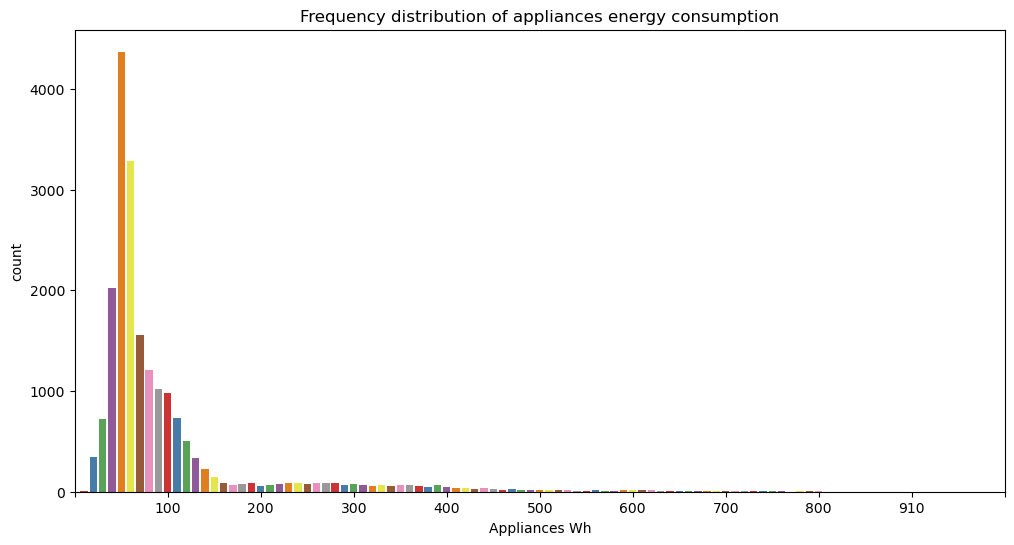

In [47]:
#Appliances energy consumption distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Appliances', data=df, palette='Set1')
plt.xlabel('Appliances Wh')
plt.title('Frequency distribution of appliances energy consumption')
# Set x-axis ticks
plt.xticks(np.arange(-1, 100, 10))
plt.show()


As can be seen the data distribution has a longtail, but it distributed widely, so will be kept
And also, appliances energy consumption has the most frequency ranges from about 20 to 150 W/h

since it is required to analysis time series data, let us see the relationship between time and appliance (Candanedo et al 2017, p. 85)

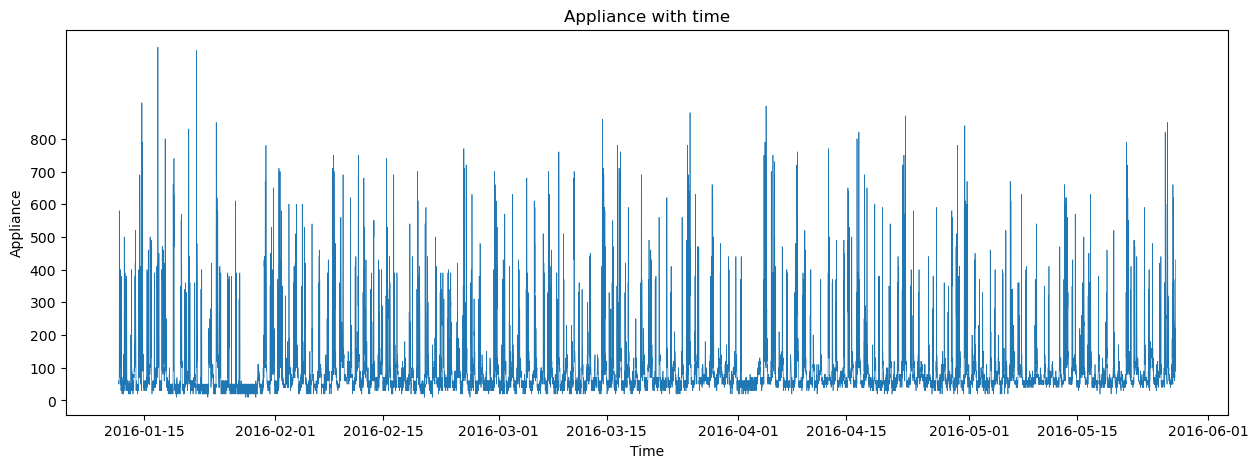

In [48]:
# draw line chart
fig = plt.figure(figsize=(15,5))
plt.plot(df['Date'],df['Appliances'],linewidth=0.5)
# set notation and title
plt.title("Appliance with time")
plt.yticks(range(0, 900, 100))
# plt.xticks(range(0, 15000000, 2500000))
plt.xlabel("Time")
plt.ylabel("Appliance")

plt.show()

This line chart shows a certain regularity in electricity consumption over the months. Roughly speaking, there is a slight increase at the beginning of each month, a slight overall decrease in the middle, and an increase again towards the end of the month.


let us look closerly, line chart for only January is presented below.

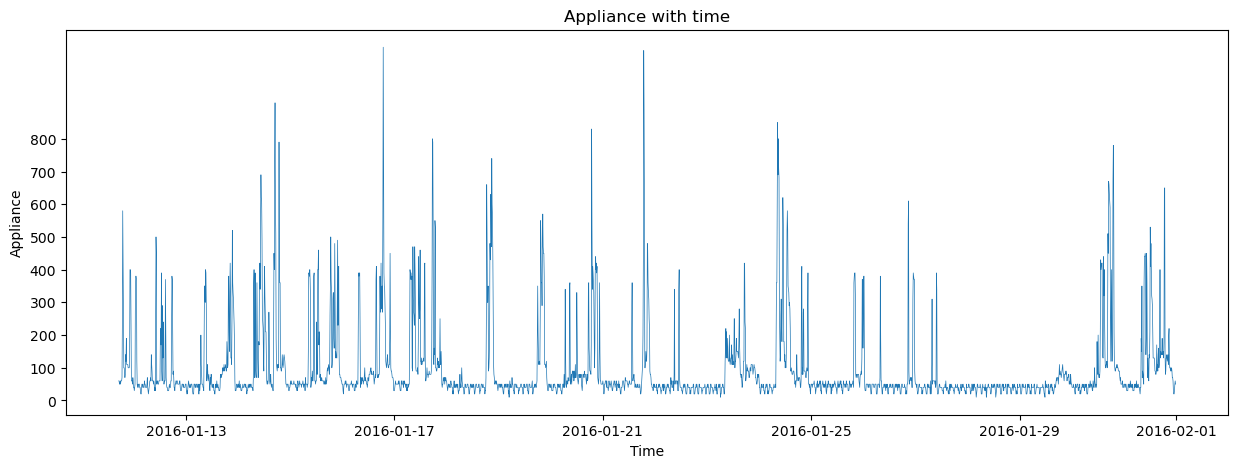

In [49]:
# Convert 'Date' column to pandas datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# Filter data for January 2016
jan_data = df[(df['Date'].dt.year == 2016) & (df['Date'].dt.month == 1)]

# draw line chart
fig = plt.figure(figsize=(15,5))
plt.plot(jan_data['Date'],jan_data['Appliances'],linewidth=0.5)
# set notation and title
plt.title("Appliance with time")
plt.yticks(range(0, 900, 100))

plt.xlabel("Time")
plt.ylabel("Appliance")

plt.show()

This displays the energy usage pattern during a specific time period, and the energy consumption profile exhibits a significant level of fluctuation.There is no apparent seasonal influence.

let us watch much closer, see how appliances changes with hours weekly in January (Candanedo et al 2017, p. 87)

In [50]:
#An hourly heat map was created for four consecutive weeks of data to identify any time trends
f = 0
count = 0
week_number=1
for day in df_first_four_weeks['Day_of_week']:
    count=count+1
    if day == 7 and df_first_four_weeks['Day_of_week'][count]==1:
        # Create a sub-DataFrame for the current week
        df_current_week = df_first_four_weeks[f:count]
        # Pivot table to create heatmap data
        heatmap_data = df_current_week.pivot_table(index='Time_period', columns='Day_of_week', values='Appliances')
        
        # Plot heatmap
        plt.figure()  # Create a new figure for each week
        sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Appliances'})
        plt.title(f"Week {week_number} in January")
        plt.show()

        f=count
        week_number=week_number+1

From a daily perspective, it can be seen that the electricity consumption is mainly concentrated in the afternoon, but there is no obvious specific time. Sometimes it is in the afternoon, and sometimes it is in the evening. From a weekly perspective, there is no significant pattern in electricity consumption. Sometimes it is concentrated on Mondays and Tuesdays, and sometimes it is concentrated on weekends.

Overall, the seasonal influence doesn't appear to be particularly significant for most time scales; however, there is some regularity observed on a daily basis and between months.

In [51]:
#now remove the Date object column
df.drop(columns='Date',inplace=True)

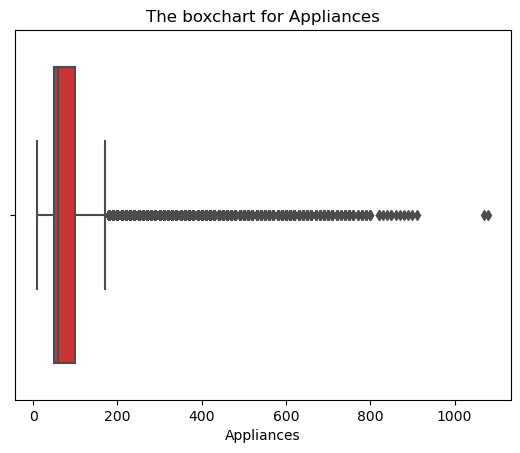

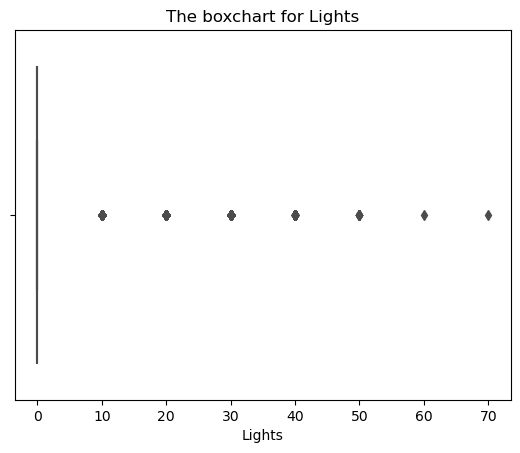

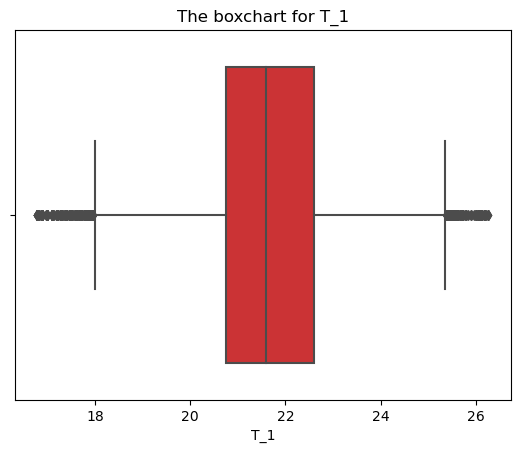

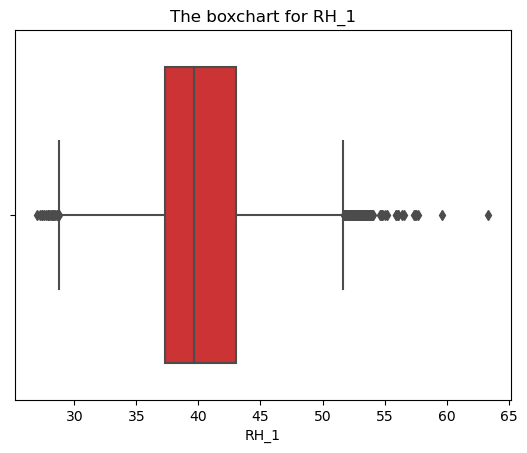

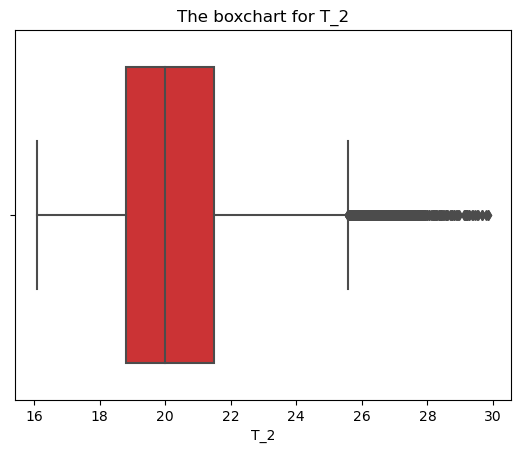

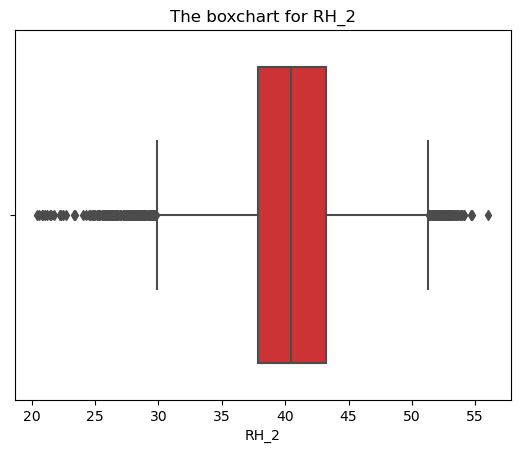

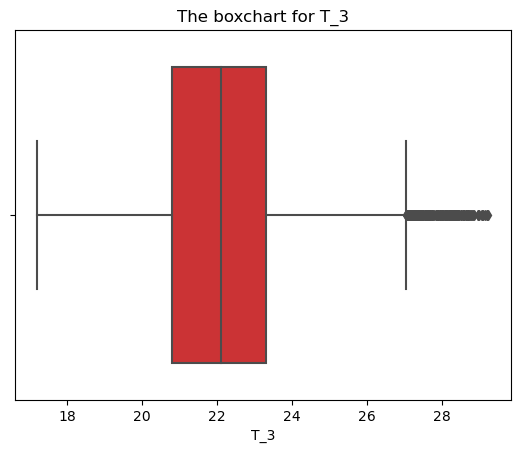

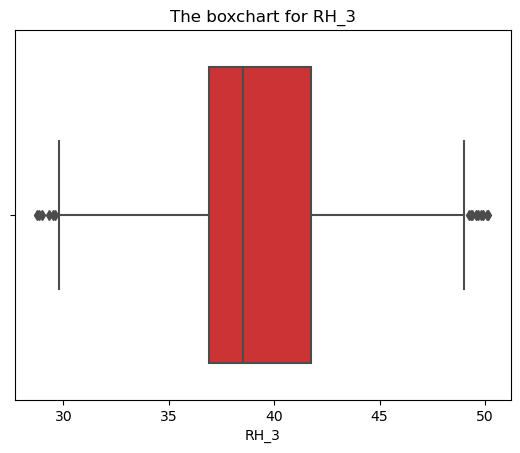

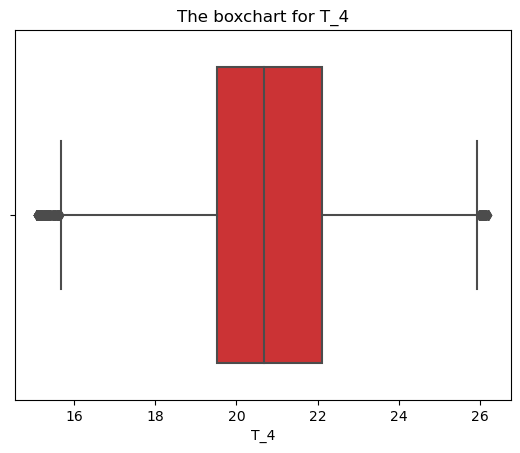

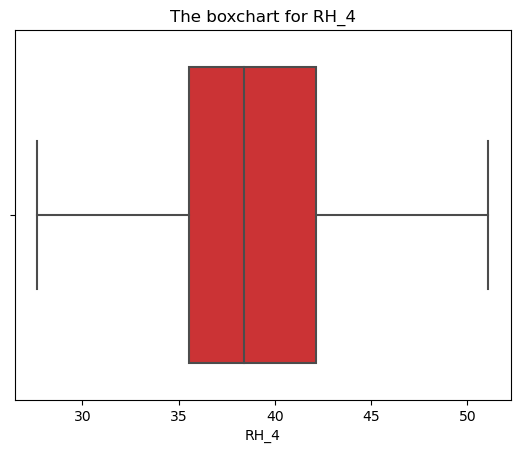

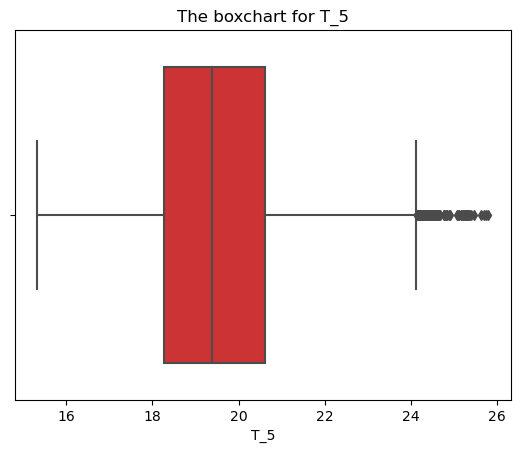

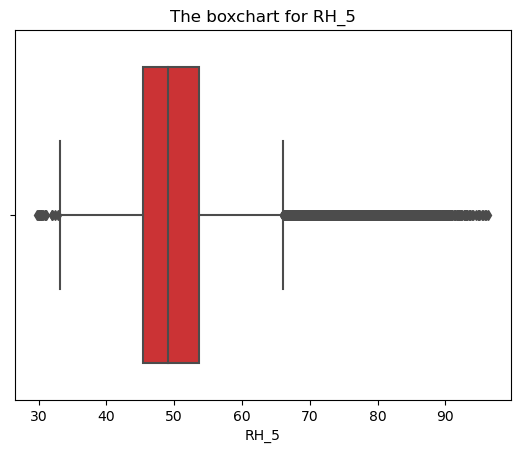

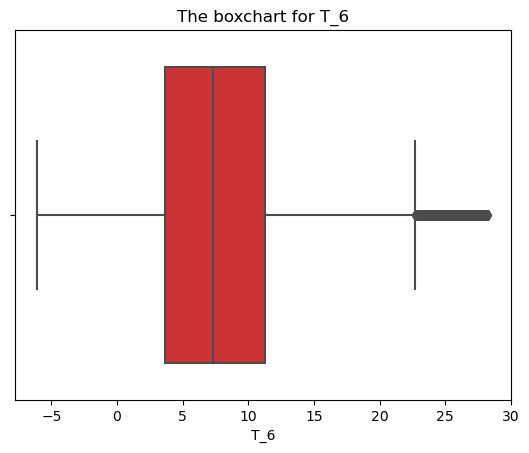

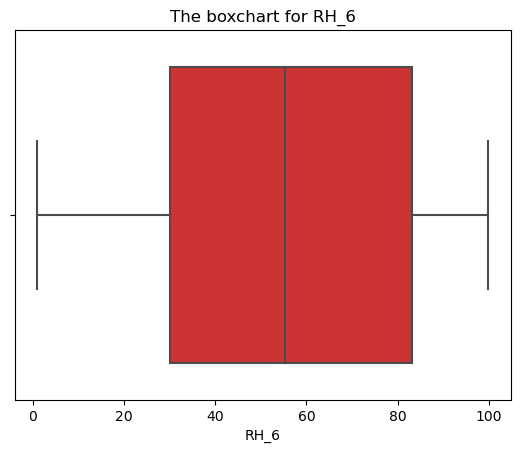

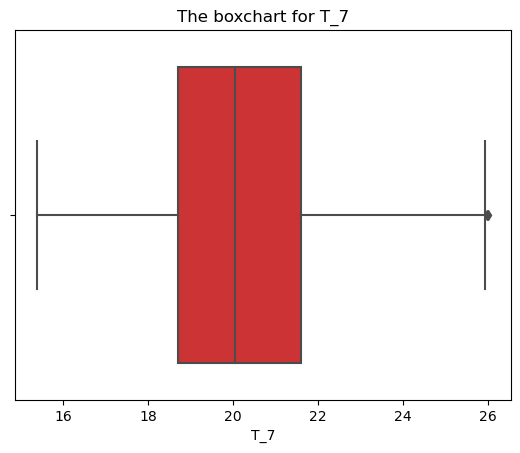

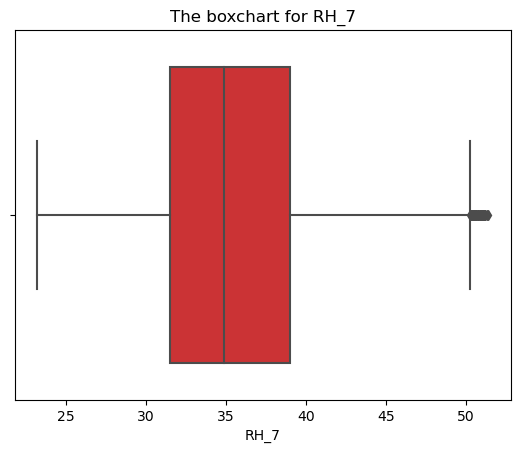

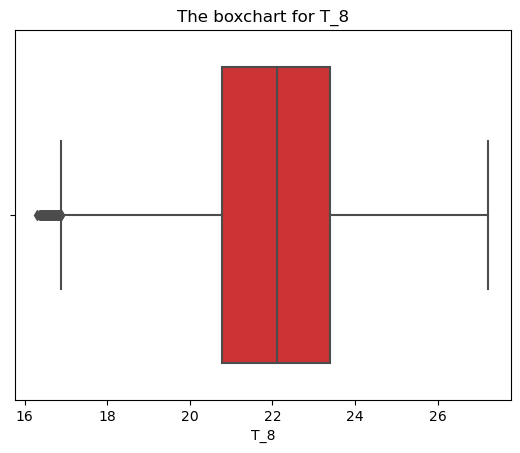

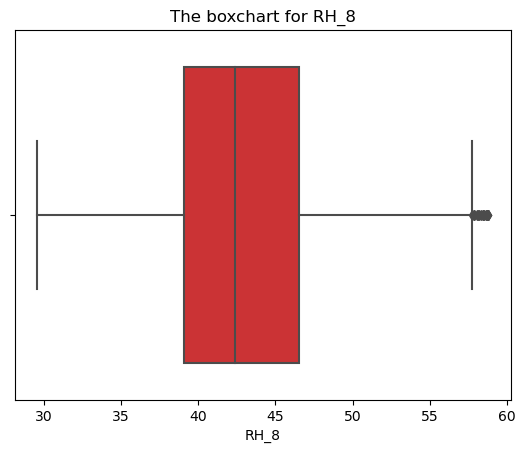

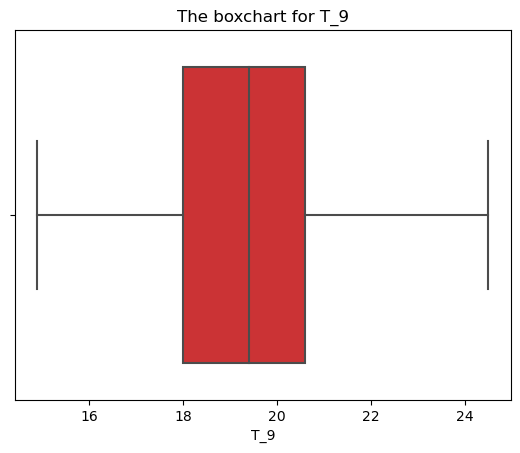

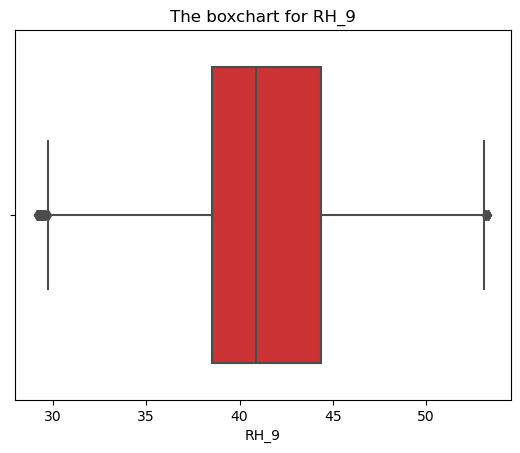

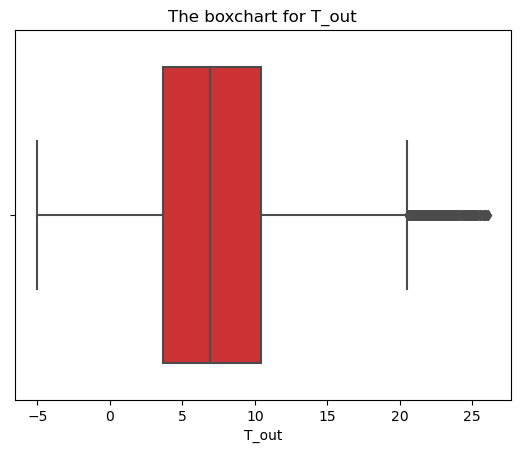

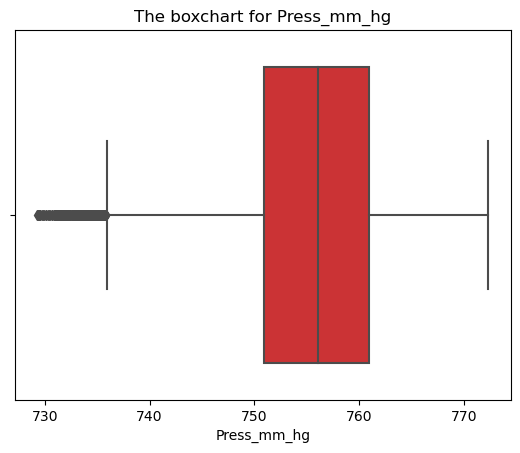

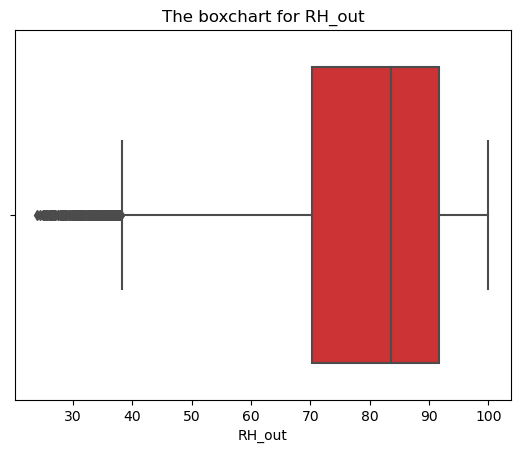

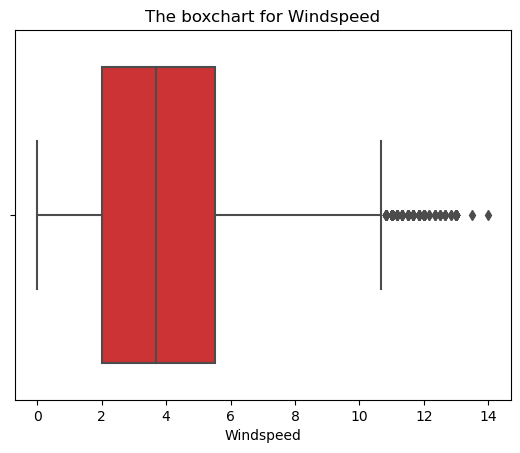

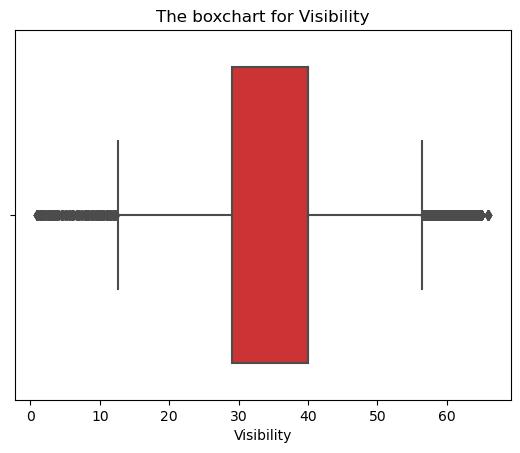

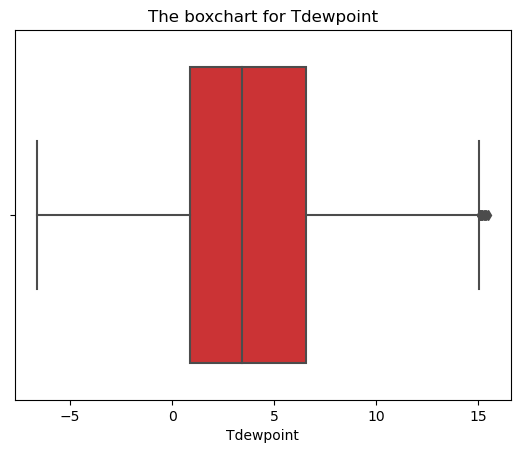

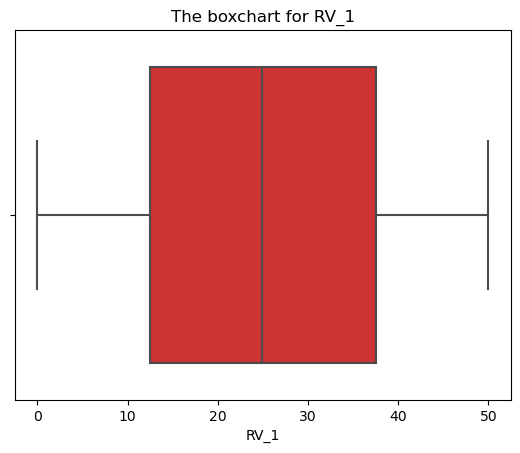

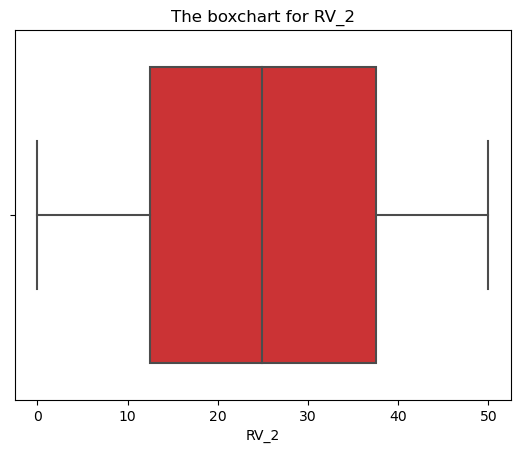

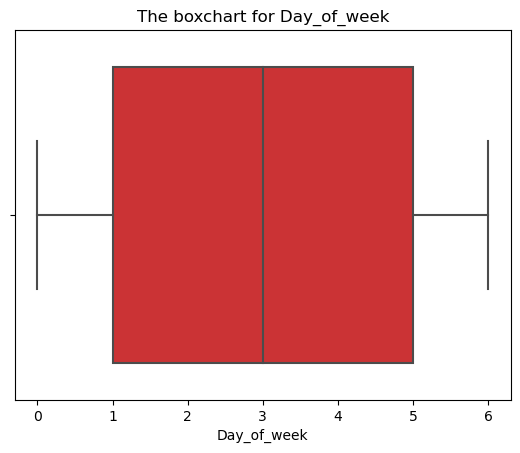

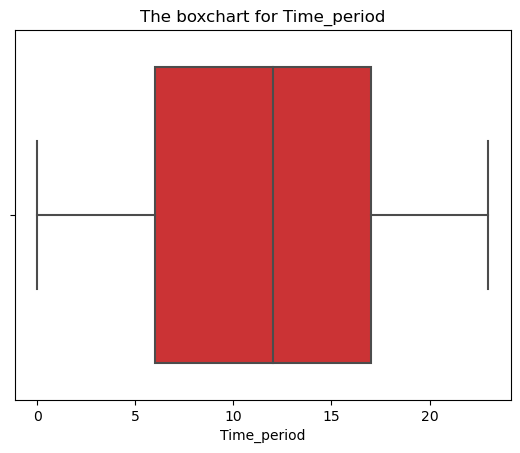

In [52]:
#show each features' boxplot
for featrue in df.columns:
    sns.boxplot(x=df[featrue][0:], data=df.iloc[0:], order=df[featrue]
                [0:].value_counts().index, palette='Set1')
    plt.title("The boxchart for {}".format(featrue))
    plt.show()


now we can see that there are amount of outliners need to be handled for each feature, as it can lead to the result distortion, given the big number, the better way is to replace them with some value or just removing the few instead of removing all outliners.

In [53]:
#Dropping few outliers
for feature in df.columns:
    q_low = df[feature].quantile(0.002)  # 5th percentile
    q_high = df[feature].quantile(0.998)  # 95th percentile
    df = df[(df[feature] >= q_low) & (df[feature] <= q_high)]

In [54]:
df.isnull().sum()


Appliances     0
Lights         0
T_1            0
RH_1           0
T_2            0
RH_2           0
T_3            0
RH_3           0
T_4            0
RH_4           0
T_5            0
RH_5           0
T_6            0
RH_6           0
T_7            0
RH_7           0
T_8            0
RH_8           0
T_9            0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
RV_1           0
RV_2           0
Day_of_week    0
Time_period    0
dtype: int64

now all data is valid, we should start to see therelationships between all the variables with the energy consumption of appliances in the training set.

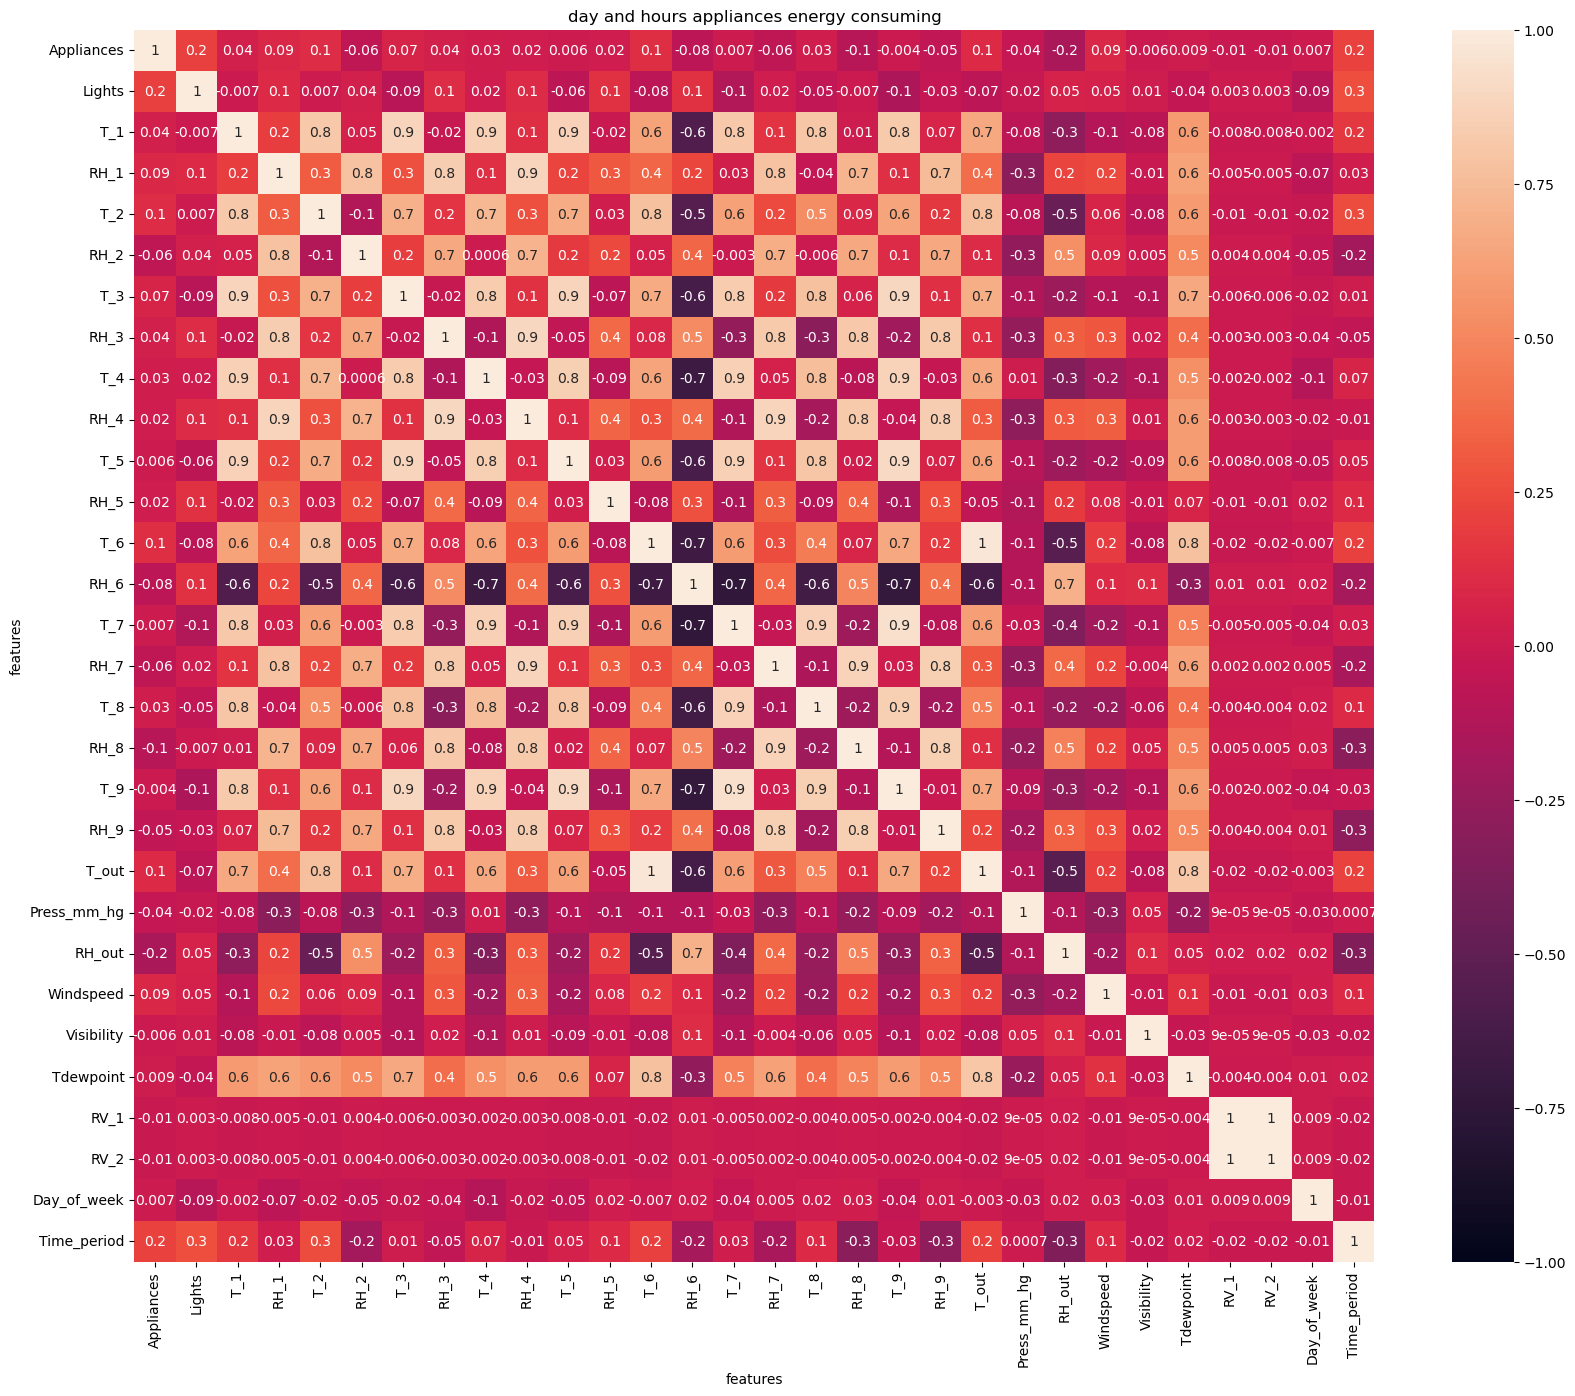

In [55]:
#relationships between all the variables with the energy consumption of appliances in the training set.
corr = df.corr()
#matrix = np.triu(corr)
plt.figure(figsize=(20, 16))
sns.heatmap(corr, vmax=1.0, vmin=-1.0, fmt='.1g', annot=True)
plt.title('day and hours appliances energy consuming')
plt.xlabel('features')
plt.ylabel('features')

# Show the plot
plt.show()


we can see how linear correlation between variables can depicted with heatmap

now let us have a more clear look at the relationship only between appliances and other features, since the appliances energy consumption is our target predict object.

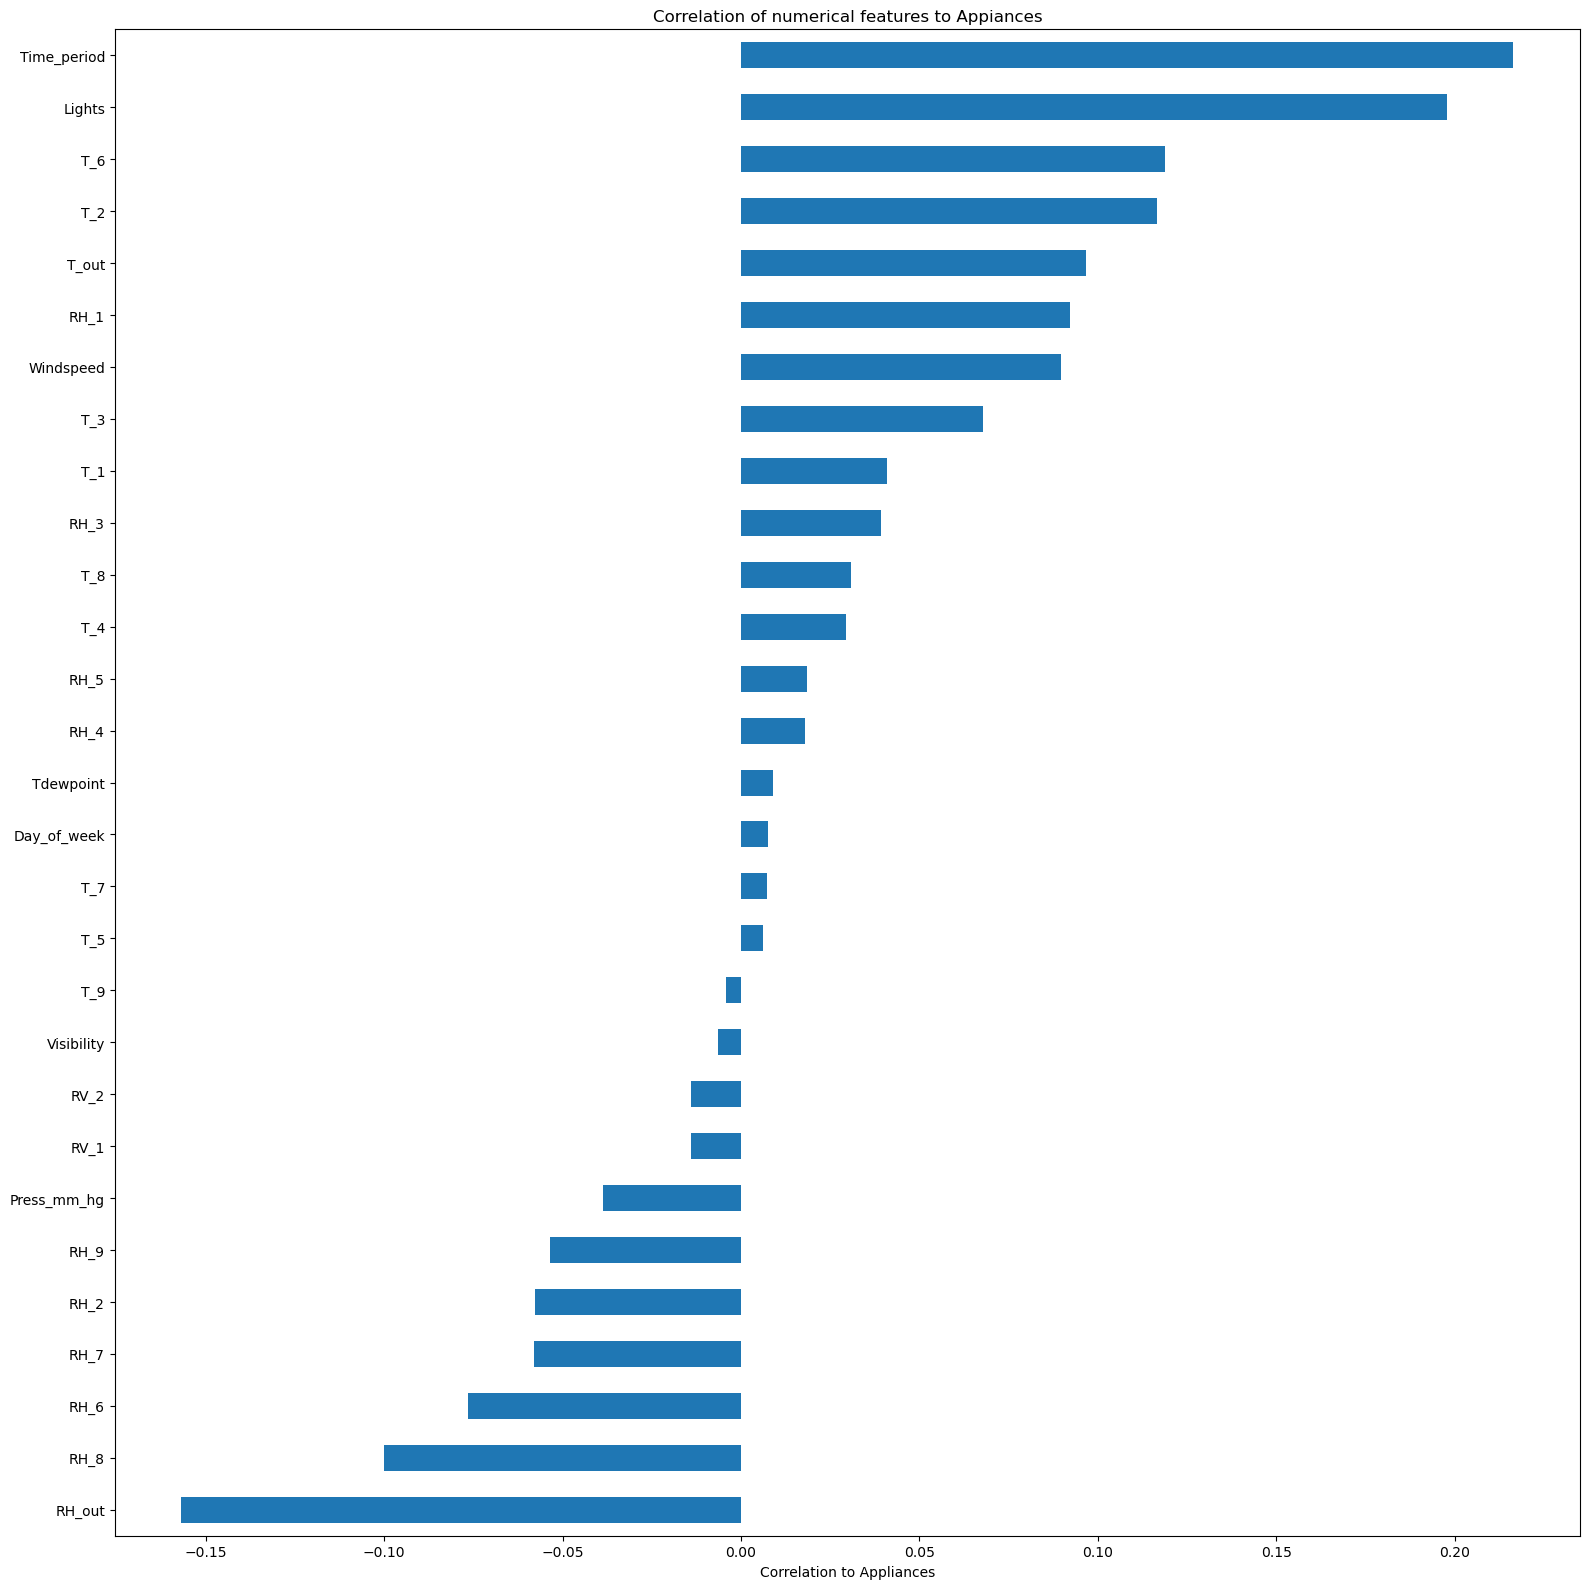

In [56]:

plt.figure(figsize=(16, 16))
corr["Appliances"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of numerical features to Appiances")
plt.xlabel("Correlation to Appliances")
plt.tight_layout()
plt.show()


According to the two graph above, the appliances have the strongest positive correlation with lights and NSM, both of which are 0.2. On the other hand, there is a negative correlation between the appliances and outdoor humidity/RH6, which is -0.08. Additionally, there are some noteworthy correlations among other features. For instance, T1 T2 T3 T4 T5 T6 T7 T8 and T9 are positively correlated with the appliances. Furthermore, an intriguing correlation exists between pressure and wind speed, which is negative at -0.2.

But the heatmap shows only linear correlations, therefore does not apply all senarios.
Let us take a more intuitive look at the linear or nonlinear relationship between energy consumption and each feature.

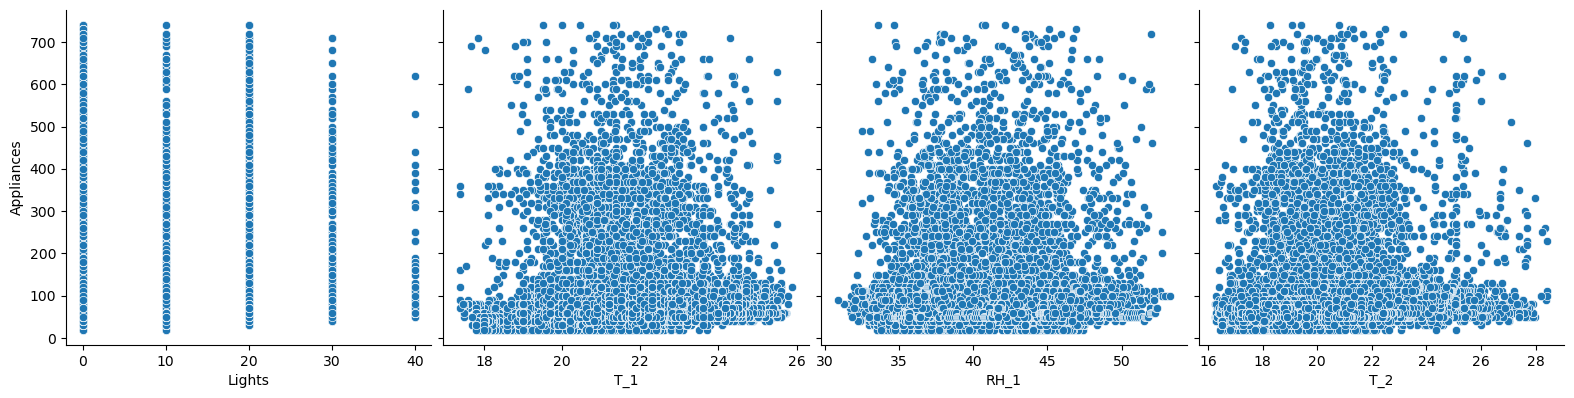

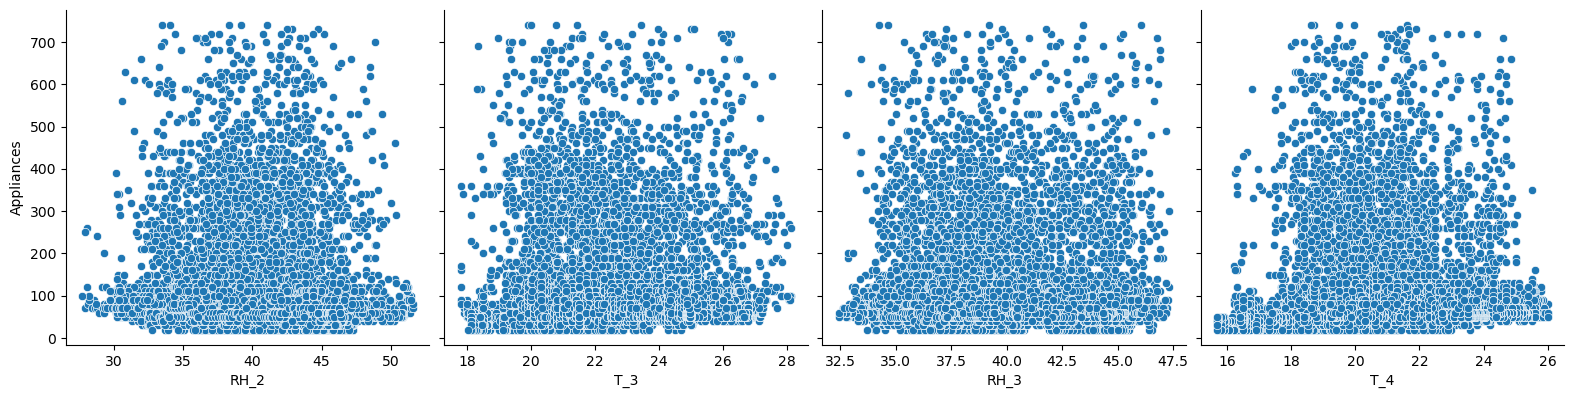

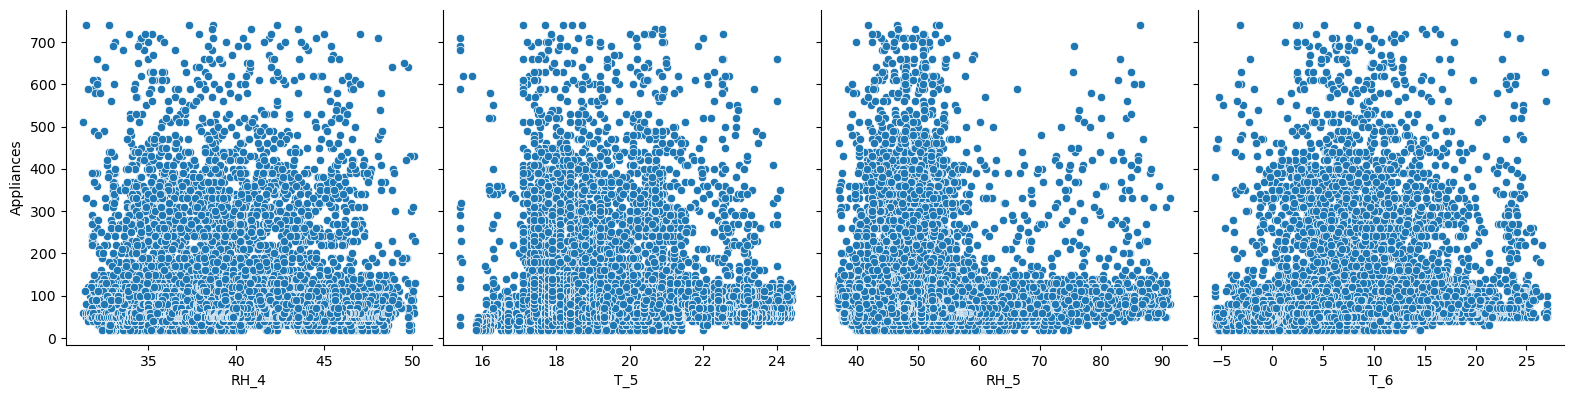

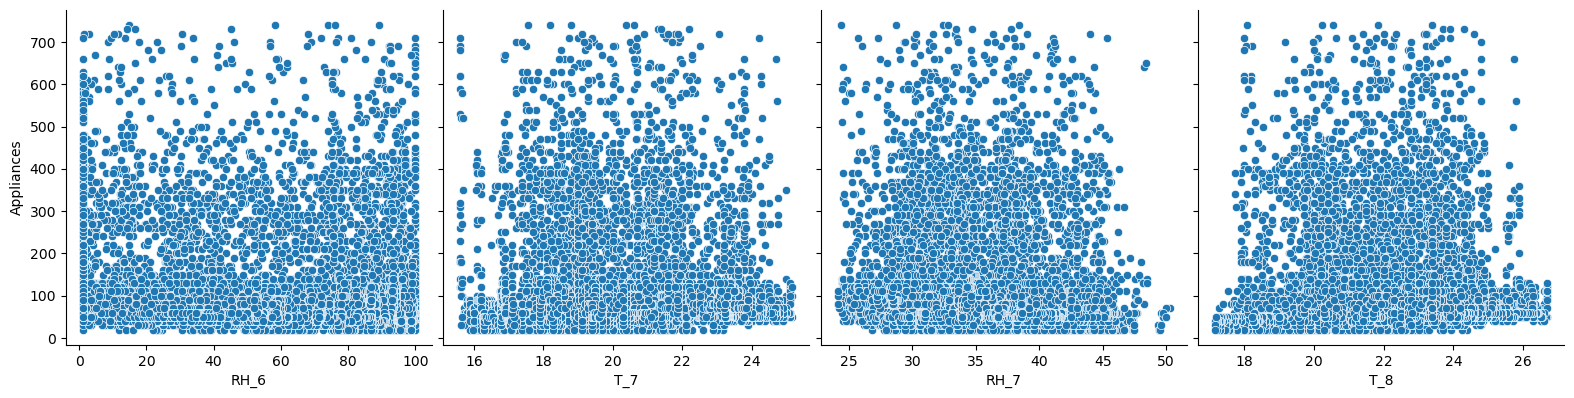

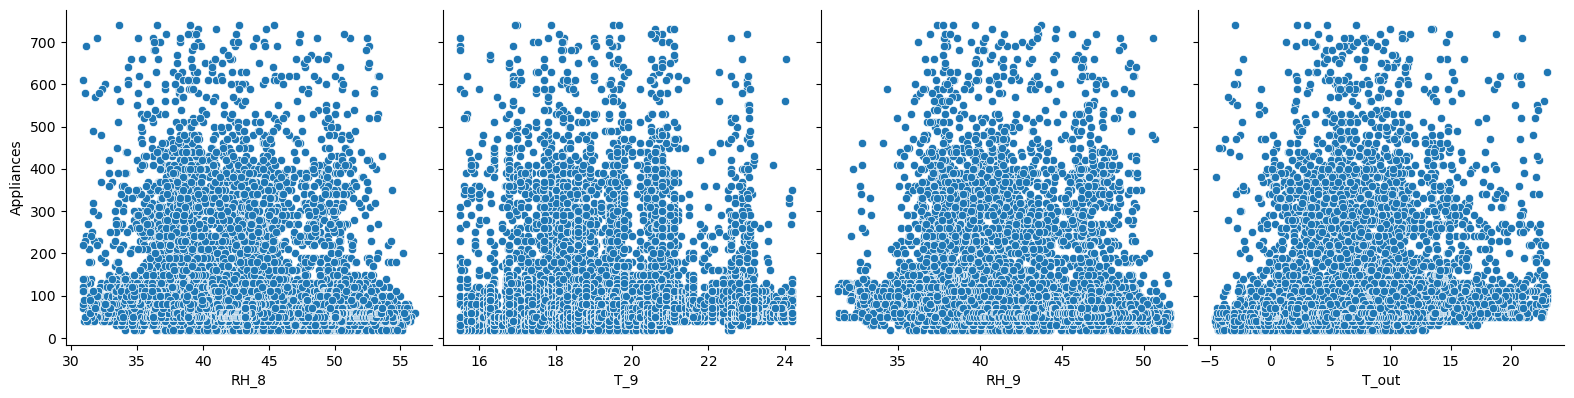

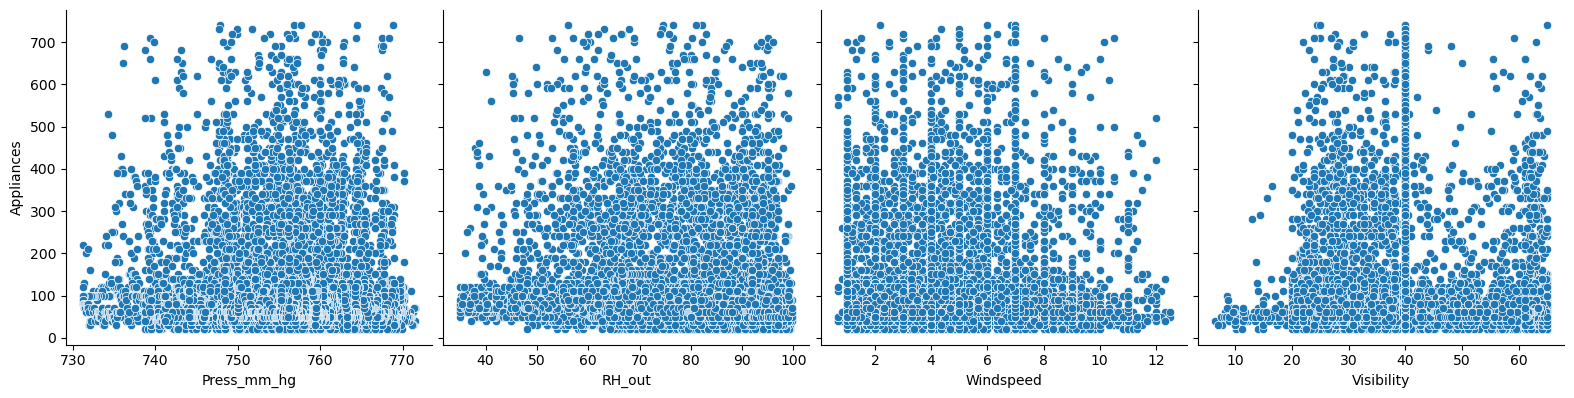

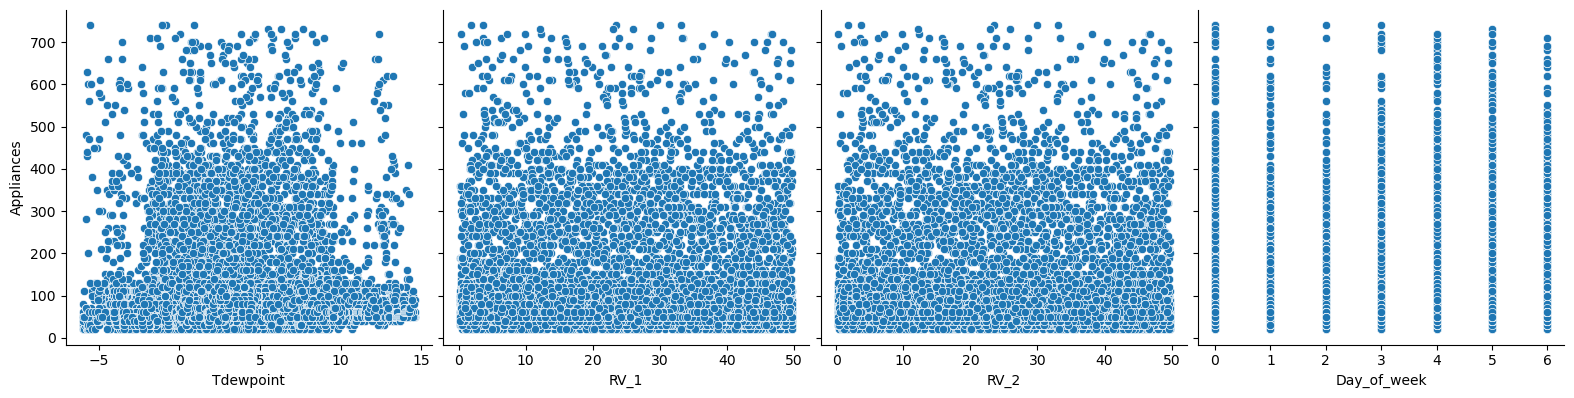

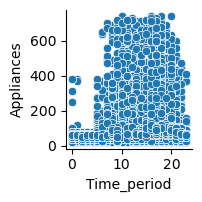

In [57]:

def pp(w, x, y, z):
    sns.pairplot(df, x_vars=[
                 w, x, y, z], y_vars='Appliances', height=4, aspect=1, kind='scatter')
    plt.show()

pp('Lights', 'T_1', 'RH_1', 'T_2')
pp('RH_2', 'T_3', 'RH_3', 'T_4')
pp('RH_4', 'T_5', 'RH_5', 'T_6')
pp('RH_6', 'T_7', 'RH_7', 'T_8')
pp('RH_8', 'T_9', 'RH_9', 'T_out')
pp('Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility')
pp('Tdewpoint', 'RV_1', 'RV_2', 'Day_of_week')
sns.pairplot(df, x_vars=['Time_period'], y_vars='Appliances', height=2, aspect=1, kind='scatter')
plt.show()
# pp('Time_period')

From the plot, it can be seen that there is no direct plot that can show a linear relationship between them and energy consumption.

therefore, we can apply L1 regularisation to confirm and delete some unimportant featrues

In [58]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Define feature matrix X and Appliances y
X = df.drop('Appliances', axis=1)  # drop the target variable from the feature matrix
y = df['Appliances']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Initialize Lasso regression model with alpha=0.1
lasso = Lasso(alpha=0.1)

# Fit the Lasso model to the training data
lasso.fit(X_train, y_train)

# Get the coefficients of the Lasso model
lasso_coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})

# Select the features with non-zero coefficients
important_features = lasso_coefs.loc[lasso_coefs['Coefficient']
                                     != 0, 'Feature']

# Print the important features
print('Important Features:', important_features.to_list())


Important Features: ['Lights', 'T_1', 'RH_1', 'T_2', 'RH_2', 'T_3', 'RH_3', 'T_4', 'RH_4', 'T_5', 'RH_5', 'T_6', 'RH_6', 'T_7', 'RH_7', 'T_8', 'RH_8', 'T_9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'RV_1', 'RV_2', 'Day_of_week', 'Time_period']


In [59]:

df.columns

Index(['Appliances', 'Lights', 'T_1', 'RH_1', 'T_2', 'RH_2', 'T_3', 'RH_3',
       'T_4', 'RH_4', 'T_5', 'RH_5', 'T_6', 'RH_6', 'T_7', 'RH_7', 'T_8',
       'RH_8', 'T_9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'RV_1', 'RV_2', 'Day_of_week',
       'Time_period'],
      dtype='object')

In [60]:
df.head()

,Appliances,Lights,T_1,RH_1,T_2,RH_2,T_3,RH_3,T_4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,RV_1,RV_2,Day_of_week,Time_period
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,0,17
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,0,17
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,0,17
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,0,17
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,0,17


there is no featrues need to be removed accroding L1 regularisation.

#### Prepare data for model

I selected three models: standard LSTM, Stateful LSTM (with memory), and ARIMA.

Standard LSTMs are ideal for various time series with non-linear relationships and multiple inputs (Brownlee 2017), as observed in the provided dataset.

Stateful LSTMs are beneficial when data demonstrates a temporal pattern (Brownlee 2017), with the given dataset displaying certain regularity between months.

ARIMA models are favored for their simplicity, interpretability, and reliable forecasting across diverse time series data (Hayes 2022).


In [61]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [62]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [63]:
# load the dataset
dataset = df.values
print(dataset)
dataset = dataset.astype('float32')
df.shape

[[ 60.          30.          19.89       ...  13.27543316   0.
   17.        ]
 [ 60.          30.          19.89       ...  18.60619498   0.
   17.        ]
 [ 50.          30.          19.89       ...  28.64266817   0.
   17.        ]
 ...
 [270.          10.          25.5        ...  29.19911708   4.
   17.        ]
 [420.          10.          25.5        ...   6.32278365   4.
   17.        ]
 [430.          10.          25.5        ...  34.11885059   4.
   18.        ]]


(17891, 30)

In [64]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [65]:
# Create a separate scaler for the target variable (Appliances)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(dataset[:, 0].reshape(-1, 1))

MinMaxScaler()

split train and test data

In [66]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#Data for ARIMA
df['Time'] = pd.to_datetime(df['Day_of_week'].astype(str) + " " + df['Time_period'].astype(str) + ':00', format="%w %H:%M")
df = df.set_index('Time')
hourly_data = df['Appliances'].resample('H').sum()

train_arima = hourly_data.iloc[:int(0.8*len(hourly_data))]
valid_arima = hourly_data.iloc[int(0.8*len(hourly_data)):]

# train_arima = df.iloc[:int(0.8*len(df))]
# valid_arima = df.iloc[int(0.8*len(df)):]

In [67]:

# reshape into X=t and Y=t+1
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX.shape

(11982, 3, 30)

### 3. Implement prediction models

In [68]:
# create LSTM_standard 
LSTM_standard = Sequential()
LSTM_standard.add(LSTM(4, input_shape=(look_back,30)))
LSTM_standard.add(Dense(1))
LSTM_standard.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
# create LSTM_memory
batch_size = 1
LSTM_memory = Sequential()
LSTM_memory.add(LSTM(4, batch_input_shape=(batch_size, look_back,30), stateful=True))
LSTM_memory.add(Dense(1))
LSTM_memory.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
# create ARIMA
# base on day change
ARIMA_auto = auto_arima(train_arima, start_p=1, start_q=1, max_p=3, max_q=3, m=24,
                   start_P=0, seasonal=True, d=1, D=0, trace=True,
                   error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=389.078, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=384.699, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=387.512, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=386.998, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=386.883, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=386.699, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=386.699, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=388.699, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=386.273, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=384.998, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=387.290, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[24] intercept
Total fit time: 0.377 seconds


/Users/yangqingyan/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yangqingyan/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/yangqingyan/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/yangqingyan/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


### 4. Train prediction models

In [71]:
# standard LSTM
LSTM_standard.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# stateful LSTM
for i in range(100):
	LSTM_memory.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	LSTM_memory.reset_states()

# ARIMA
ARIMA_auto.fit(train_arima)

Epoch 1/100


2023-05-05 11:10:14.640221: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11982/11982 - 13s - loss: 0.0114 - 13s/epoch - 1ms/step
Epoch 2/100
11982/11982 - 10s - loss: 0.0091 - 10s/epoch - 821us/step
Epoch 3/100
11982/11982 - 9s - loss: 0.0090 - 9s/epoch - 750us/step
Epoch 4/100
11982/11982 - 8s - loss: 0.0088 - 8s/epoch - 655us/step
Epoch 5/100
11982/11982 - 8s - loss: 0.0088 - 8s/epoch - 649us/step
Epoch 6/100
11982/11982 - 8s - loss: 0.0087 - 8s/epoch - 656us/step
Epoch 7/100
11982/11982 - 9s - loss: 0.0086 - 9s/epoch - 750us/step
Epoch 8/100
11982/11982 - 9s - loss: 0.0086 - 9s/epoch - 717us/step
Epoch 9/100
11982/11982 - 8s - loss: 0.0085 - 8s/epoch - 657us/step
Epoch 10/100
11982/11982 - 9s - loss: 0.0084 - 9s/epoch - 720us/step
Epoch 11/100
11982/11982 - 9s - loss: 0.0084 - 9s/epoch - 732us/step
Epoch 12/100
11982/11982 - 9s - loss: 0.0083 - 9s/epoch - 732us/step
Epoch 13/100
11982/11982 - 9s - loss: 0.0083 - 9s/epoch - 718us/step
Epoch 14/100
11982/11982 - 9s - loss: 0.0083 - 9s/epoch - 736us/step
Epoch 15/100
11982/11982 - 8s - loss: 0.0082 - 8s/epo

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 24),
      suppress_warnings=True)

In [72]:
#standard LSTM
y_trainPredict_LSTM_standard = LSTM_standard.predict(trainX)

#stateful LSTM
y_trainPredict_LSTM_memory = LSTM_memory.predict(trainX, batch_size=batch_size)
LSTM_memory.reset_states()

11982/11982 [==============================] - 5s 381us/step


In [73]:
# Invert predictions for LSTM
y_trainPredict_LSTM_standard = target_scaler.inverse_transform(y_trainPredict_LSTM_standard)
y_trainPredict_LSTM_memory = target_scaler.inverse_transform(y_trainPredict_LSTM_memory)
trainY = target_scaler.inverse_transform(trainY.reshape(-1, 1))

In [74]:
# predict the R-squared value of train data(Fernando 2021)
# This allows to evaluate how well the model is fitting the training data.
# to ensure that the model is not overfitting on the training data.

print('R-squared value of train data by standard LSTM: ' + str(metrics.r2_score(y_true=trainY, y_pred=y_trainPredict_LSTM_standard)))

print('R-squared value of train data by LSTM with memory: ' +
      str(metrics.r2_score(y_true=trainY, y_pred=y_trainPredict_LSTM_memory)))


R-squared value of train data by standard LSTM: 0.6469016019845275
R-squared value of train data by LSTM with memory: 0.6017115873593264


The results of the R-squared value shows that the standard LSTM had better performance than stateful LSTM on train dataset. R-squared isn't suitable for assessing ARIMA models, as it assumes linearity while ARIMA can capture linear and non-linear relationships in time series data.

### 5. Test predictin models and show results

(Fernando 2021) R2 helps in assessing how well the model fits the data, (Glen 2018) while RMSE helps in evaluating the accuracy of the model's predictions. 

In [75]:
# standard LSTM
y_testPredict_LSTM_standard = LSTM_standard.predict(testX)
# stateful LSTM
y_testPredict_LSTM_memory = LSTM_memory.predict(testX,batch_size=batch_size)
# ARIMA 
y_predict_ARIMA = ARIMA_auto.predict(n_periods=len(valid_arima))

5901/5901 [==============================] - 2s 413us/step


In [76]:
# Invert predictions for LSTM
y_testPredict_LSTM_standard = target_scaler.inverse_transform(y_testPredict_LSTM_standard)
y_testPredict_LSTM_memory = target_scaler.inverse_transform(y_testPredict_LSTM_memory)
testY = target_scaler.inverse_transform(testY.reshape(-1, 1))

In [77]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#R-squared value of test data
# standard LSTM
print('R-squared value of test data by standard LSTM:' + str(metrics.r2_score(y_true=testY, y_pred=y_testPredict_LSTM_standard)))
# stateful LSTM
print('R-squared value of test data by LSTM with memory:' +
      str(metrics.r2_score(y_true=testY, y_pred=y_testPredict_LSTM_memory)))


#RMSE value of test data
print('RMSE value of test data by standard LSTM is: \n',
       np.sqrt(mean_squared_error(testY, y_testPredict_LSTM_standard)))
print ('RMSE value of test data by LSTM with memory is: \n', 
       np.sqrt(mean_squared_error(testY, y_testPredict_LSTM_memory)))

print ('RMSE value of test data by ARIMA is: \n',
       np.sqrt(mean_squared_error(valid_arima,y_predict_ARIMA)))


R-squared value of test data by standard LSTM:0.4328411858965363
R-squared value of test data by LSTM with memory:0.3749989728149097
RMSE value of test data by standard LSTM is: 
 0.08912137
RMSE value of test data by LSTM with memory is: 
 0.09355562
RMSE value of test data by ARIMA is: 
 75325.48092473895


As can be seen that the RMSE values for standard LSTM and stateful LSTM are low (0.081 and 0.088), while ARIMA's is much higher (6872.20). Low RMSEs for LSTM models indicate better predictions, while the high ARIMA RMSE value suggests poorer performance, maybe is because the given dataset shows more assocciation of non-leaner and without pronounced trend.

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

In [78]:
# Create a dictionary with the data
# the RMSE value for ARIMA is far bigger than the others, to have a clear comparison, I set a 'big' number instead
result = {'Model': ['Linear Regression', 'Random Forest', 'GBM','Standard LSTM','Stateful LSTM','ARIMA'],
        'R-squared': [0.2769, 0.6719, 0.4475,0.5288,0.4492,0],
        'RMSE': [0.3244, 0.1472, 0.2479,0.0812,0.0878,2.2037],
        }

# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(result)

# Print the DataFrame
print(df)

               Model  R-squared    RMSE
0  Linear Regression     0.2769  0.3244
1      Random Forest     0.6719  0.1472
2                GBM     0.4475  0.2479
3      Standard LSTM     0.5288  0.0812
4      Stateful LSTM     0.4492  0.0878
5              ARIMA     0.0000  2.2037


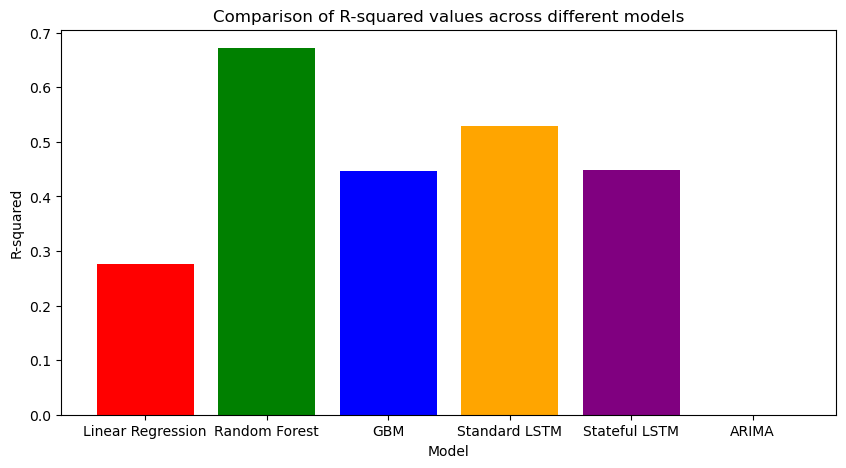

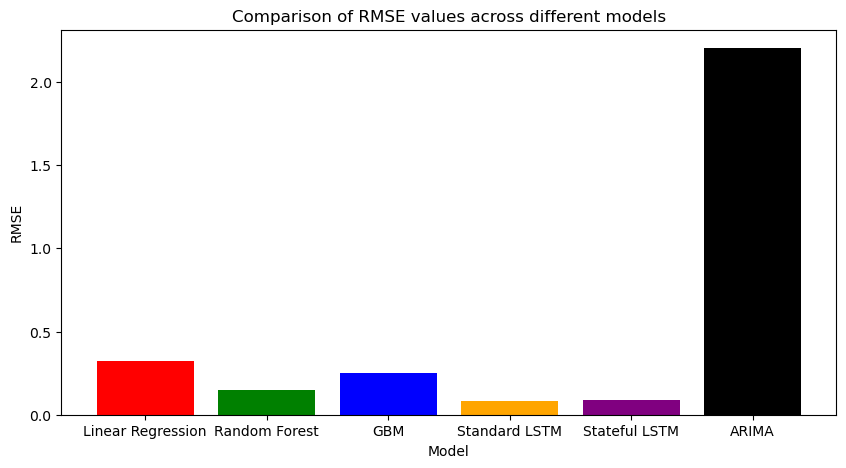

In [79]:
def showBar(b):
    # Create bar graph
    plt.figure(figsize=(10, 5))
    # Set bar colors
    colors = ['red', 'green', 'blue', 'orange', 'purple','black']
    plt.bar(result['Model'], result[b],color=colors)

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(b)
    plt.title('Comparison of ' + b + ' values across different models')
    # Show graph
    plt.show()

showBar('R-squared')
showBar('RMSE')


The R-squared value indicates the model's performance, with higher values indicating better performance. Among the same dataset, random forest performs the best, followed closely by standard LSTM. Stateful LSTM and GBM perform reasonably well with similar values, while linear regression performs the worst. ARIMA is not suitable for R-squared as a metric.

The RMSE value indicates the model's performance, with smaller values indicating better performance. Standard LSTM ranks first in this case, followed by stateful LSTM, both of which significantly outperform non-time-series models. ARIMA's high RMSE value suggests that it is not suitable for this non-linear, trend-lacking data.

Overall, the random forest and standard LSTM model appears to perform the best among the all selected models.

### 7. Reflect on what you have learned by completing this assignment

Through this assignment, I have learned that not all models require the same input data. We need to prepare different forms of data for different models. Some models require multiple input features to obtain more accurate training results, while others only need the target variable value. When selecting models, we should not simply choose time-series models just because they are typical for certain problems. Instead, we should assess the characteristics of the given data, such as linearity, non-linearity, trend, and non-trend, to determine which model to choose.

### 8. References

Brownlee, J 2017, A Gentle Introduction to Long Short-Term Memory Networks by the Experts, Machine Learning Mastery, viewed 4 May 2023, 
<https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/>.

Brownlee, J 2017, Stateful and Stateless LSTM for Time Series Forecasting with Python, Machine Learning Mastery, viewed 4 May 2023, 
<https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/>.

Candanedo, LM, Feldheim, V, & Deramaix, D 2017,'Data driven prediction models of energy use of appliances in a low-energy house', Energy and Buildings, vol. 140, pp. 81-97.

Fernando, J 2021, R-Squared Formula, Regression, and Interpretations, investopedia, viewed 25 Mar 2023, <https://www.investopedia.com/terms/r/r-squared.asp>.

Glen, S, RMSE: Root Mean Square Error, Statistics How To, viewed 25 Mar 2023, 
<https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/>.

Hayes, A 2012, Autoregressive Integrated Moving Average (ARIMA) Prediction Model, Investopedia, viewed 4 May 2023, 
<https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp>.